**TASK 4**

i didn't particularly make separate functions, instead i put everything in separate cells, so that it's easier to read and understand.

In [11]:
#imports
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# Load the metadata file
metadata = pd.read_csv("D:/FAST_NUCES/7thSemester/DLP/Assignment/Assignment1/Dataset/SkinCancer/archive/ham10000_metadata.csv")

metadata 

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [4]:
# Load the images folder + Preprocess
imageslocation = 'D:/FAST_NUCES/7thSemester/DLP/Assignment/Assignment1/Dataset/SkinCancer/archive/HAM10000_images_part_1'

# Define the new image size
new_size = (224, 224)

# Load the images from the folder and resize them
images = []
labels = []
for filename in os.listdir(imageslocation):
    if filename.endswith(".jpg"):
        image = cv2.imread(os.path.join(imageslocation, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, new_size)
        images.append(image)
        label = metadata[metadata["image_id"] == filename.split(".")[0]]["dx"].values[0]
        labels.append(label)

# Convert the images to NumPy arrays
images = np.array(images)

# Preprocess the images
images = images.astype("float32") / 255


In [5]:
# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)



In [6]:
def Display_N_Training_Images(train_images, train_labels, test_images, test_labels, N):
    # Display the first N images from the training set and their labels
    print("Display the first", N, "images from the training set and their labels:")
    for i in range(N):
        plt.figure()
        plt.imshow(train_images[i])
        plt.title(train_labels[i])
        plt.show()
    
    # Display the first N images from the testing set and their labels
    print("Display the first", N, "images from the testing set and their labels:")
    for i in range(N):
        plt.figure()
        plt.imshow(test_images[i])
        plt.title(test_labels[i])
        plt.show()

Display the first 5 images from the training set and their labels:


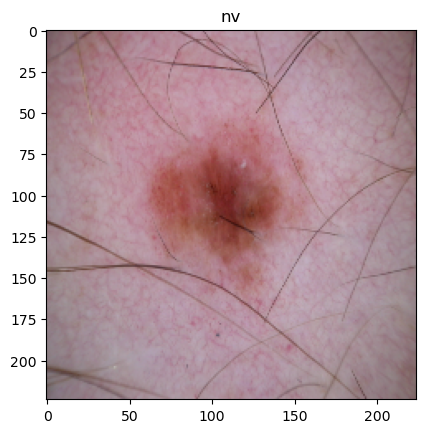

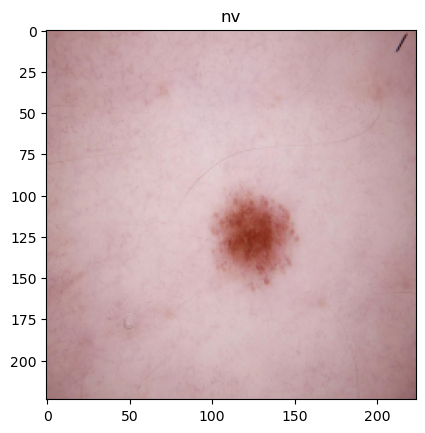

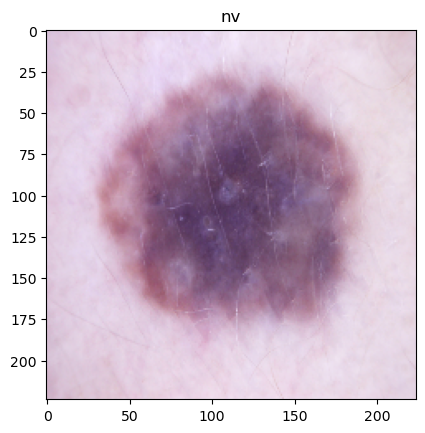

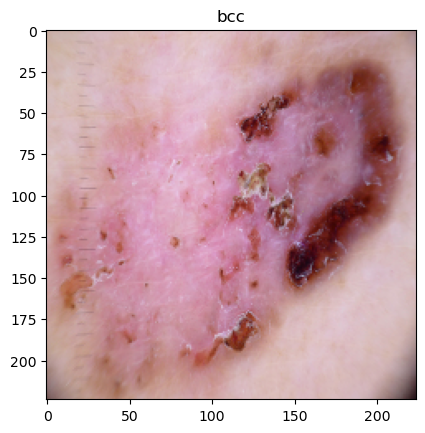

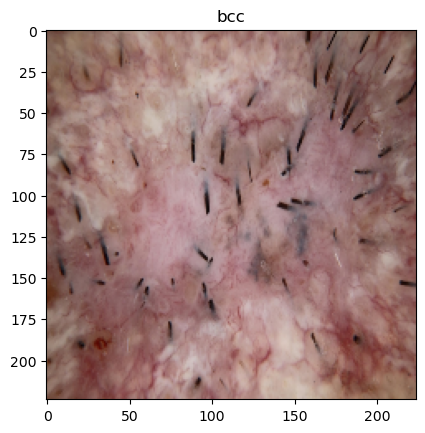

Display the first 5 images from the testing set and their labels:


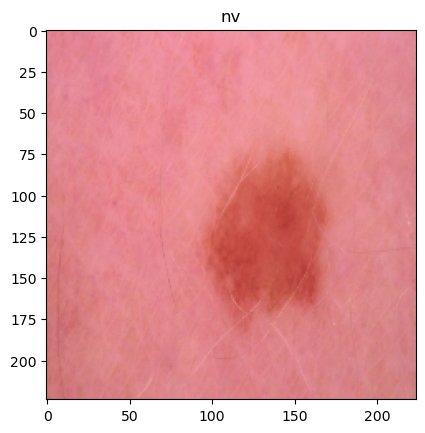

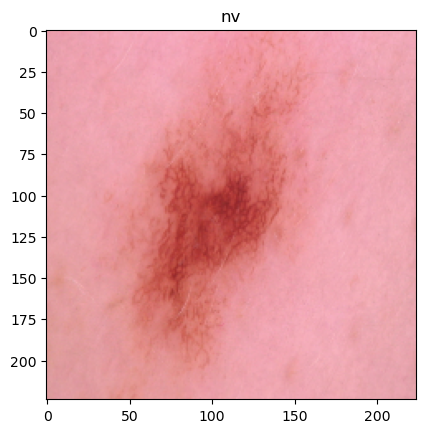

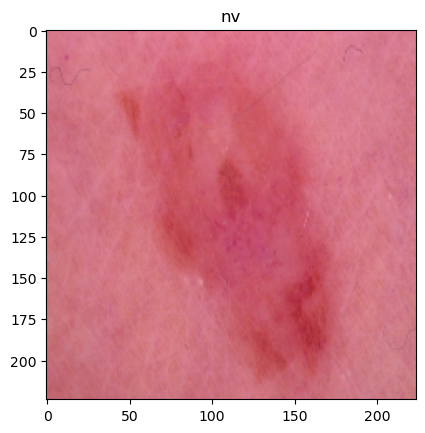

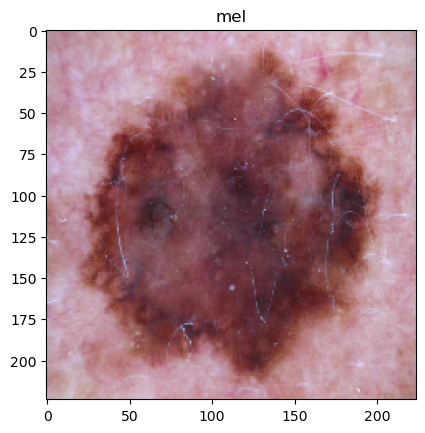

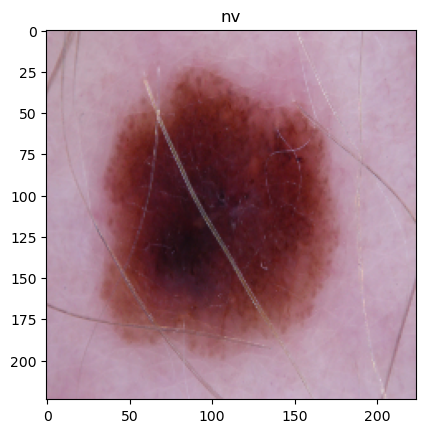

In [9]:
Display_N_Training_Images(train_images, train_labels, test_images, test_labels, 5)

In [15]:
# Encode the labels
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
test_labels = encoder.transform(test_labels)


In [19]:
# Train an MLP model on the training set
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Extract features from the skin cancer images using the pre-trained model
train_features = base_model.predict(train_images)
test_features = base_model.predict(test_images)



63/63 [==============================] - 96s 2s/step


In [30]:
#Defined a call back function to stop training when accuracy reaches 98%
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.98:                 
                print("\nReached 98% accuracy so cancelling training!")
                
                # Stop training once the above condition is met
                self.model.stop_training = True
# Instantiate class
callback = myCallback()

In [31]:
# Train an MLP model on top of the extracted features
train_features = np.reshape(train_features, (train_features.shape[0], 25088)) #this is the output shape of the VGG16 model featuremap
test_features = np.reshape(test_features, (test_features.shape[0], 25088))
input = 25088
model = models.Sequential([
    layers.Flatten(input_shape=(input,)),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="tanh"),
    layers.Dense(64, activation="relu"),
    layers.Dense(7, activation="softmax")
])

model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
model.fit(train_features, train_labels, epochs=50, validation_data=(test_features, test_labels),callbacks=[callback])
model.save('cancer_model.h5')


Epoch 1/50
251/251 [==============================] - 5s 19ms/step - loss: 1.0130 - accuracy: 0.6689 - val_loss: 0.9784 - val_accuracy: 0.6745
Epoch 2/50
251/251 [==============================] - 5s 18ms/step - loss: 0.9554 - accuracy: 0.6802 - val_loss: 0.9295 - val_accuracy: 0.6865
Epoch 3/50
251/251 [==============================] - 5s 19ms/step - loss: 0.9246 - accuracy: 0.6802 - val_loss: 0.9591 - val_accuracy: 0.6860
Epoch 4/50
251/251 [==============================] - 5s 19ms/step - loss: 0.8957 - accuracy: 0.6897 - val_loss: 0.8930 - val_accuracy: 0.6900
Epoch 5/50
251/251 [==============================] - 5s 18ms/step - loss: 0.8696 - accuracy: 0.6951 - val_loss: 0.8573 - val_accuracy: 0.7034
Epoch 6/50
251/251 [==============================] - 5s 18ms/step - loss: 0.8306 - accuracy: 0.7099 - val_loss: 0.9002 - val_accuracy: 0.6960
Epoch 7/50
251/251 [==============================] - 5s 18ms/step - loss: 0.7947 - accuracy: 0.7204 - val_loss: 0.8765 - val_accuracy: 0.6805

In [14]:
from tensorflow.keras.applications import Adam

#Model without base VGG16 support:
# Split the dataset into training and testing sets
train_images2, test_images2, train_labels2, test_labels2 = train_test_split(images, labels, test_size=0.2)

# Encode the labels
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
test_labels = encoder.transform(test_labels)

model = models.Sequential([
    layers.Flatten(input_shape=(224 * 224 * 3,)),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="tanh"),
    layers.Dense(64, activation="relu"),
    layers.Dense(7, activation="softmax")
])


optimizer = Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(train_images.reshape(-1, 224 * 224 * 3), train_labels2, epochs=100)

63/63 [==============================] - 1s 11ms/step - loss: 0.9560 - accuracy: 0.6680
Test accuracy: 0.6679980158805847


In [ ]:
# Evaluate the model on the test set
test_loss2, test_accuracy2 = model.evaluate(test_images.reshape(-1, 224 * 224 * 3), test_labels2)

# Print the test loss and accuracy
print("Test loss:", test_loss2)
print("Test accuracy:", test_accuracy2)

**EVALUATION METRICS**

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
# Get the predicted labels for the test set
test_prob = model.predict(test_features)
# Get the predicted labels by taking the index of the class with the highest probability
test_pred = np.argmax(test_prob, axis=1)

63/63 [==============================] - 0s 4ms/step


In [42]:
#Find all the evaluation metrics for both models
accuracy_bm = accuracy_score(test_labels, test_pred)
precision_bm = precision_score(test_labels, test_pred, average='macro')
recall_bm = recall_score(test_labels, test_pred, average='macro')
f1_bm = f1_score(test_labels, test_pred, average='macro')

print("Accuracy: ", accuracy_bm)
print("Precision: ", precision_bm)
print("Recall: ", recall_bm)
print("F1: ", f1_bm)

Accuracy:  0.7578632051922117
Precision:  0.6028883661285782
Recall:  0.47050058276057083
F1:  0.4861533935550916


<AxesSubplot:title={'center':'Confusion Matrix for Task2: GridSearchCV Model'}>

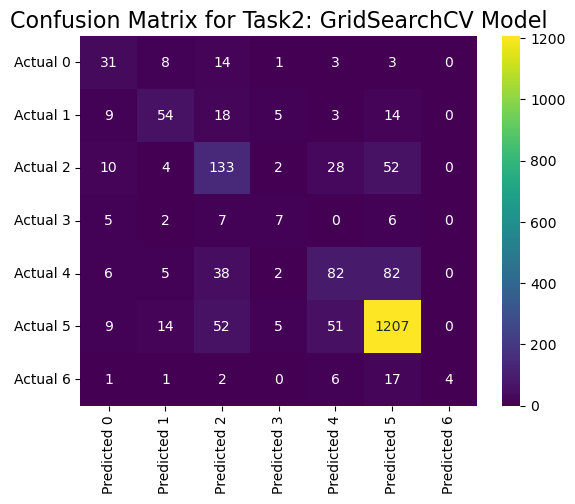

In [40]:
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
#Writing Function for Confusion Matrix
def plot_conf_mat(y_test,y_pred):
    labels = unique_labels(y_test)
    column = [f'Predicted {label}' for label in labels]
    indexx = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_test,y_pred), columns=column, index=indexx)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

#plotting their confusion matrices
plt.title('Confusion Matrix for Task2: GridSearchCV Model', fontsize=16, loc='center')
plot_conf_mat(test_labels,test_pred)
